# 01. Data Preprocessing

This notebook handles:
1. Loading real data from multiple sources.
2. Defining `BrainDataset` with class mapping.
3. Visualization of data and augmentations.
4. Creating Train/Val splits.

In [1]:
import os
import torch
import numpy as np
# import cv2  <-- Removed unused import
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt

# Configuration
DATA_ROOT = '../Data'
CLASSES = ['hemorrhagic', 'ischemic', 'tumor']
IMG_SIZE = 224
BATCH_SIZE = 32

# Define paths to source data for each class
# Mapping based on implementation plan
DATA_SOURCES = {
    'hemorrhagic': [
        os.path.join(DATA_ROOT, 'Brain_Stroke_CT_Dataset', 'Bleeding')
    ],
    'ischemic': [
        os.path.join(DATA_ROOT, 'Brain_Stroke_CT_Dataset', 'Ischemia')
    ],
    'tumor': [
        os.path.join(DATA_ROOT, 'archive (1)', 'Training', 'glioma'),
        os.path.join(DATA_ROOT, 'archive (1)', 'Training', 'meningioma'),
        os.path.join(DATA_ROOT, 'archive (1)', 'Training', 'pituitary')
    ]
}

## 1. Dataset Class

In [2]:
class BrainDataset(Dataset):
    def __init__(self, data_sources, classes, transform=None):
        self.data_sources = data_sources
        self.classes = classes
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        self._prepare_data()
        
    def _prepare_data(self):
        for label_idx, class_name in enumerate(self.classes):
            if class_name not in self.data_sources:
                continue
                
            sources = self.data_sources[class_name]
            for source_dir in sources:
                if not os.path.exists(source_dir):
                    print(f"Warning: Directory not found: {source_dir}")
                    continue
                    
                print(f"Loading {class_name} from {source_dir}...")
                valid_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tif')
                files = [f for f in os.listdir(source_dir) if f.lower().endswith(valid_exts)]
                
                for fname in files:
                    self.image_paths.append(os.path.join(source_dir, fname))
                    self.labels.append(label_idx)
                    
        print(f"Total images loaded: {len(self.image_paths)}")

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        path = self.image_paths[idx]
        label = self.labels[idx]
        
        try:
            img = Image.open(path).convert('RGB')
        except Exception as e:
            print(f"Error loading {path}: {e}")
            # Return a blank black image in case of error (or could skip)
            img = Image.new('RGB', (IMG_SIZE, IMG_SIZE))
            
        if self.transform:
            img = self.transform(img)
            
        return img, label

# Transforms
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create Dataset
full_dataset = BrainDataset(DATA_SOURCES, CLASSES, transform=train_transforms)

Loading hemorrhagic from ../Data/Brain_Stroke_CT_Dataset/Bleeding...
Loading ischemic from ../Data/Brain_Stroke_CT_Dataset/Ischemia...
Loading tumor from ../Data/archive (1)/Training/glioma...
Loading tumor from ../Data/archive (1)/Training/meningioma...
Loading tumor from ../Data/archive (1)/Training/pituitary...
Total images loaded: 4117


## 2. Train/Val Split

In [3]:
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

Training samples: 3293
Validation samples: 824


## 3. Visualization

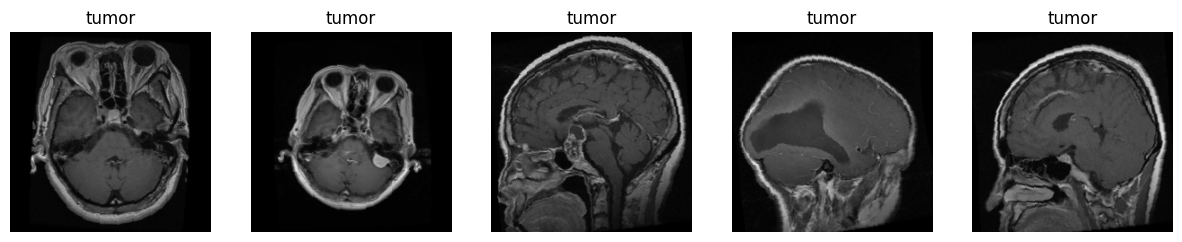

In [4]:
def denormalize(tensor):
    tensor = tensor * torch.Tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.Tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    return tensor.clamp(0, 1)

images, labels = next(iter(dataloader))

plt.figure(figsize=(15, 5))
for i in range(min(5, len(images))):
    ax = plt.subplot(1, 5, i+1)
    img_t = denormalize(images[i]).permute(1, 2, 0)
    plt.imshow(img_t)
    plt.title(CLASSES[labels[i]])
    plt.axis('off')
plt.show()